In [1]:
from fastai.collab import *
from fastai.tabular.all import *
from time import *

# 1. Train the model

## 1.1. Prepare the data

In [2]:
path = Path('.')
df = pd.read_csv(path/'training_data_v3_1.csv', delimiter=',', engine='python', header=0)

In [3]:
df.head()

,date,mor_temp,mor_humid,mor_wspd,mor_wdeg,mor_cloud,mor_weather_id,noo_temp,noo_humid,noo_wspd,noo_wdeg,noo_cloud,noo_weather_id,aft_temp,aft_humid,aft_wspd,aft_wdeg,aft_cloud,aft_weather_id,daily_power
0,2011-10-10,16.798571,82.285714,7.285714,250.000000,62.142857,803,18.784,69.6,7.60,244.0,32.0,802,16.752857,77.857143,7.000000,250.000000,45.000000,802,6.40
1,2011-10-11,15.838571,81.428571,7.142857,245.714286,62.142857,802,17.404,74.4,6.40,252.0,75.0,803,16.172857,79.000000,6.100000,247.142857,67.142857,803,4.80
2,2011-10-26,10.331429,83.000000,4.857143,194.285714,77.142857,803,13.438,63.4,5.80,186.0,51.0,803,10.824286,74.857143,2.428571,148.571429,9.000000,800,10.10
3,2011-10-27,9.051429,80.285714,3.428571,111.428571,56.571429,803,16.068,58.2,5.60,142.0,75.0,803,12.577143,77.285714,2.142857,131.428571,67.142857,803,10.02
4,2011-10-28,11.831429,84.857143,1.428571,177.142857,49.571429,801,17.372,67.4,1.29,194.6,17.0,801,13.801429,81.714286,1.198571,132.857143,44.285714,802,9.40


The sun rises and sets at different time during year. Therefore time, interm of day and month is also an important factor to predict the solar energy.

In [4]:
day_list = []
month_list = []
for i in range(len(df)):
    day_list.append(int(df.date[i][8:]))
    month_list.append(int(df.date[i][5:7]))
df['day'] = day_list
df['month'] = month_list

In [5]:
df.head()

,date,mor_temp,mor_humid,mor_wspd,mor_wdeg,mor_cloud,mor_weather_id,noo_temp,noo_humid,noo_wspd,...,noo_weather_id,aft_temp,aft_humid,aft_wspd,aft_wdeg,aft_cloud,aft_weather_id,daily_power,day,month
0,2011-10-10,16.798571,82.285714,7.285714,250.000000,62.142857,803,18.784,69.6,7.60,...,802,16.752857,77.857143,7.000000,250.000000,45.000000,802,6.40,10,10
1,2011-10-11,15.838571,81.428571,7.142857,245.714286,62.142857,802,17.404,74.4,6.40,...,803,16.172857,79.000000,6.100000,247.142857,67.142857,803,4.80,11,10
2,2011-10-26,10.331429,83.000000,4.857143,194.285714,77.142857,803,13.438,63.4,5.80,...,803,10.824286,74.857143,2.428571,148.571429,9.000000,800,10.10,26,10
3,2011-10-27,9.051429,80.285714,3.428571,111.428571,56.571429,803,16.068,58.2,5.60,...,803,12.577143,77.285714,2.142857,131.428571,67.142857,803,10.02,27,10
4,2011-10-28,11.831429,84.857143,1.428571,177.142857,49.571429,801,17.372,67.4,1.29,...,801,13.801429,81.714286,1.198571,132.857143,44.285714,802,9.40,28,10


Date is useless now, so it can be dropped out.

In [6]:
df.drop(['date'], axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mor_temp        3285 non-null   float64
 1   mor_humid       3285 non-null   float64
 2   mor_wspd        3285 non-null   float64
 3   mor_wdeg        3285 non-null   float64
 4   mor_cloud       3285 non-null   float64
 5   mor_weather_id  3285 non-null   int64  
 6   noo_temp        3285 non-null   float64
 7   noo_humid       3285 non-null   float64
 8   noo_wspd        3285 non-null   float64
 9   noo_wdeg        3285 non-null   float64
 10  noo_cloud       3285 non-null   float64
 11  noo_weather_id  3285 non-null   int64  
 12  aft_temp        3285 non-null   float64
 13  aft_humid       3285 non-null   float64
 14  aft_wspd        3285 non-null   float64
 15  aft_wdeg        3285 non-null   float64
 16  aft_cloud       3285 non-null   float64
 17  aft_weather_id  3285 non-null   i

To avoid overfit, 15% of the original dataset will be hiden from the model and be used later as the test set.

In [8]:
train_df = df[:2792]
test_df = df[2792:]

fastai determines which columns should be treated as categorical variables by comparing the number of distinct levels in the variable to the value of *max_card*

In [9]:
cont_df,cat_df = cont_cat_split(train_df, max_card = 100, dep_var = 'daily_power')

In [10]:
df[cat_df].nunique()

mor_weather_id    20
noo_weather_id    21
aft_weather_id    21
day               31
month             12
dtype: int64

The data must be normalized before being fed to the neural network:

In [11]:
procs_nn = [Categorify, Normalize]
splits = RandomSplitter(0.2)(range_of(train_df))
to_nn = TabularPandas(train_df, procs_nn, cat_df, cont_df, splits=splits, y_names='daily_power')

In [12]:
dls = to_nn.dataloaders(150)

In [13]:
y = to_nn.train.y
y.min(), y.max()

(0.0, 34.04)

## 1.2. Train the model

In [14]:
from fastai.tabular.all import*

In [110]:
learn = tabular_learner(dls, layers=[1000,500], wd=0.02, y_range=(-0.2, 34.5), n_out=1, loss_func=F.mse_loss, metrics=rmse)

fastai provides a learner used specifically for tabular data. The *weight decay* factor of this model is set to 0.02. The range of output is slightly larger than its actual range, giving the model the ability to predict more precisely values that are close to the limit. The *mean squared error* is used as the loss function. The metric *RMSE* is simply the square root of *MSE*.

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0003311311302240938)

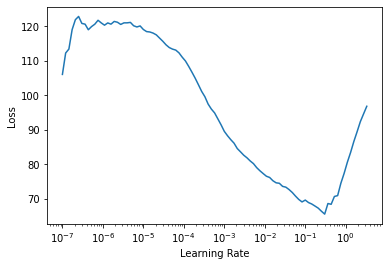

In [111]:
learn.lr_find()

In [112]:
learn.fine_tune(20, 1e-1)

epoch,train_loss,valid_loss,_rmse,time
0,166.865677,181.218994,13.461761,00:00


epoch,train_loss,valid_loss,_rmse,time
0,178.178467,100.631653,10.031532,00:00
1,124.046700,59.221870,7.695575,00:00
2,95.076080,45.995564,6.782003,00:00
3,73.463203,30.209772,5.496342,00:00
4,59.669186,32.524677,5.703041,00:00
5,50.815571,33.512291,5.788980,00:00
6,45.344231,34.265942,5.853712,00:00
7,40.079647,26.747322,5.171782,00:00
8,37.190006,29.210785,5.404700,00:00
9,34.444725,28.344168,5.323924,00:00


In [113]:
preds,targs = learn.get_preds()

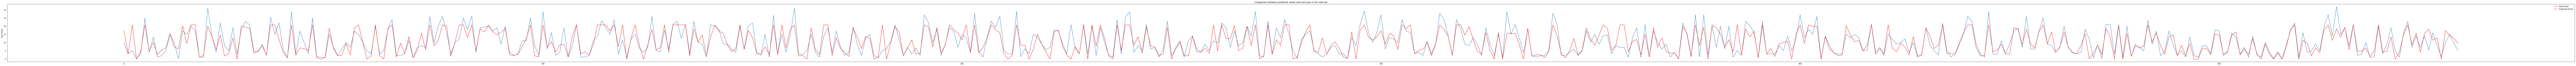

In [114]:
plt.figure(figsize=(260,6))
plt.plot(range(len(targs)), targs)
plt.plot(range(len(preds)), preds, 'r')
plt.title('Comparison between predicted values and real ones in the valid set')
plt.ylabel('Day Power')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()

As shown in the graph, the neural network can predict very well the increasing or decreasing trend of the solar power. The model presents high accuracy within the range from 5 to 25 but shows larger errors when predicting values outside that range.

# 2. Test the model with the test dataset

In [77]:
input_df = test_df.drop('daily_power', axis=1)

In [78]:
test_output = []
for i in range(len(input_df)):
    row, clas, probs = learn.predict(input_df.iloc[i])
    test_output.append(clas)

In [79]:
test_output_list = []
for i in range(len(test_output)):
    test_output_list.append(test_output[i])
test_output = torch.cat(test_output_list)

In [80]:
test_target = torch.tensor(test_df['daily_power'].values)

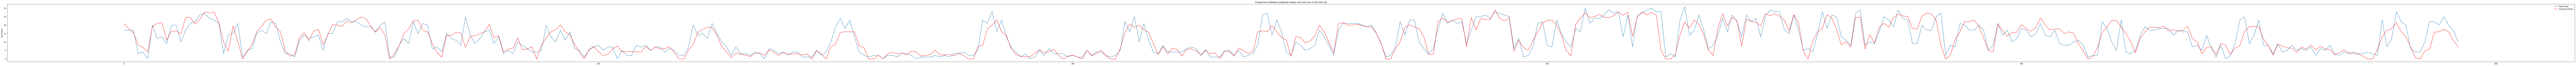

In [115]:
plt.figure(figsize=(260,6))
plt.plot(range(len(test_target)), test_target)
plt.plot(range(len(test_output)), test_output, 'r')
plt.title('Comparison between predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()

The blue line and the red line have very similar shape.

In [82]:
MSRE = math.sqrt((torch.square(test_output-test_target)).sum()/len(test_df))
print(MSRE)

4.648800685954506


The MSRE value calculated on the test set is similar to the value calculated on the training and validation set, showing no overfit in the training process.

In [40]:
#export the .pkl file
#learn.export('export_v2.pkl')

# 3. Explain the model

## 3.1 Layers in the model

In [41]:
learn.summary()

TabularModel (Input shape: 150 x torch.Size([150, 15]))
Layer (type)         Output Shape         Param #    Trainable 
                     150 x 9             
Embedding                                 180        True      
Embedding                                 198        True      
Embedding                                 180        True      
____________________________________________________________________________
                     150 x 11            
Embedding                                 352        True      
____________________________________________________________________________
                     150 x 7             
Embedding                                 91         True      
Dropout                                                        
BatchNorm1d                               30         True      
BatchNorm1d                               120        True      
____________________________________________________________________________
           

## 3.2. Permutation importance

Permutation importance is a technique in which each column is varied and the impact of each change on y values is recorded. The more "important" a independent variable is, the more its changes affect the output of the model.

The following code snippet was written by Zachary Mueller (source: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/02_Regression_and_Permutation_Importance.ipynb) to evaluate the importance of each independent variable using permutation importance technique. 

In [83]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

Getting base error


Calculating Permutation Importance


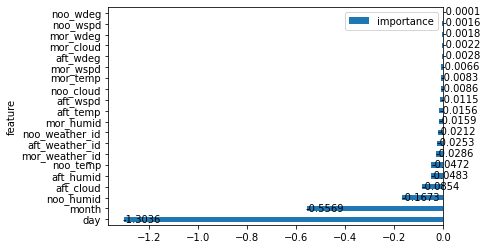

In [84]:
res = PermutationImportance(learn, train_df, bs=150)

In [86]:
res.importance

{'mor_weather_id': -0.02863101007804034,
 'noo_weather_id': -0.02124881059305831,
 'aft_weather_id': -0.025329826197315147,
 'day': -1.303592040723769,
 'month': -0.5568532071746806,
 'mor_temp': -0.008276811360376647,
 'mor_humid': -0.015886792596648446,
 'mor_wspd': -0.00657702338923493,
 'mor_wdeg': -0.001806247038392595,
 'mor_cloud': -0.002168500057802954,
 'noo_temp': -0.04724159221095665,
 'noo_humid': -0.16732252905074846,
 'noo_wspd': -0.0015937100222700173,
 'noo_wdeg': -0.0001419665962444595,
 'noo_cloud': -0.00864763954331855,
 'aft_temp': -0.015639129169911465,
 'aft_humid': -0.04830218114048405,
 'aft_wspd': -0.011451972097053066,
 'aft_wdeg': -0.0028459379767949724,
 'aft_cloud': -0.08539999009092214}

The *day* and *month* have the gihest importance. This can be explained by the relationship between the time in a year and the weather, as well as the day hours. In fact, this behaviour can be predicted if we look at solar power data over time. It shows a repeated pattern from year to year.

Beside the time data, the weather data (except the wind speed and wind degree) in the noon and afternoon also contribute to the prediction of the model.